# Laiba Batool

# i211781

# AI-A

# Generative AI Assignment 1

# **QUESTION NO 1**

In [6]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.svm import SVC
from skimage.feature import hog
import cv2
import time
import kagglehub
from tqdm import tqdm


In [7]:

# For visualization clarity
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['axes.grid'] = False
plt.rcParams['font.size'] = 12

In [8]:
class SignatureRecognition:
    def __init__(self, data_path, img_size=(128, 128), batch_size=32):
        self.data_path = data_path
        self.img_size = img_size
        self.batch_size = batch_size
        self.classes = None
        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None
        self.history = None
        self.model = None
        self.cnn_metrics = None
        self.hog_metrics = None
        self.sift_metrics = None

    def find_dataset_structure(self):
        print("Exploring dataset structure...")

        # First check direct path
        if os.path.exists(os.path.join(self.data_path, "sign_data")):
            return os.path.join(self.data_path, "sign_data")

        # If not found, recursively explore directories
        for root, dirs, files in os.walk(self.data_path):
            if "sign_data" in dirs:
                return os.path.join(root, "sign_data")
            if "train" in dirs and "test" in dirs:
                return root

        # If still not found, look for directories containing image files
        for root, dirs, files in os.walk(self.data_path):
            if any(d.endswith('_forg') for d in dirs):
                return root

        # If all else fails, return the original path
        print("Could not find specific dataset structure. Using provided path directly.")
        return self.data_path

    def load_data(self, use_train_data=True, verbose=True):
        if verbose:
            print("\nLoading signature data...")

        # Find the dataset structure
        sign_data_path = self.find_dataset_structure()

        # Check if we should use training or testing data
        if use_train_data:
            data_dir = os.path.join(sign_data_path, "train")
        else:
            data_dir = os.path.join(sign_data_path, "test")

        if verbose:
            print(f"Using data directory: {data_dir}")

        # Verify the path exists
        if not os.path.exists(data_dir):
            print(f"Warning: Directory {data_dir} does not exist!")

            # Try to find an alternative
            if os.path.exists(sign_data_path):
                all_dirs = []
                for root, dirs, _ in os.walk(sign_data_path):
                    all_dirs.extend([os.path.join(root, d) for d in dirs])

                # Filter directories that likely contain signature images
                possible_dirs = [d for d in all_dirs if any(f.lower().endswith(('.png', '.jpg', '.jpeg'))
                                                         for f in os.listdir(d) if os.path.isfile(os.path.join(d, f)))]

                if possible_dirs:
                    data_dir = possible_dirs[0]
                    if verbose:
                        print(f"Found alternative directory with images: {data_dir}")

        X = []
        y = []
        class_labels = []
        samples_per_class = {}

        # Loop through all directories in the data_dir
        for folder_name in sorted(os.listdir(data_dir)):
            folder_path = os.path.join(data_dir, folder_name)
            if os.path.isdir(folder_path):
                # Add to class labels
                class_labels.append(folder_name)
                # Extract class index
                class_idx = len(class_labels) - 1

                # Process all images in this folder
                image_count = 0
                for img_file in os.listdir(folder_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG')):
                        img_path = os.path.join(folder_path, img_file)
                        try:
                            # Read image in grayscale
                            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                            if img is None:
                                if verbose:
                                    print(f"Failed to read image: {img_path}")
                                continue

                            # Resize image
                            img = cv2.resize(img, self.img_size)

                            # Normalize image
                            img = img / 255.0

                            # Add channel dimension (for CNN)
                            img = np.expand_dims(img, axis=-1)

                            X.append(img)
                            y.append(class_idx)
                            image_count += 1
                        except Exception as e:
                            if verbose:
                                print(f"Error processing image {img_path}: {e}")

                samples_per_class[folder_name] = image_count
                if verbose:
                    print(f"  - Loaded {image_count} images for class {folder_name}")

        if not X:
            raise ValueError("No signature images were successfully loaded.")

        X = np.array(X)
        y = np.array(y)

        if verbose:
            print(f"\nTotal images loaded: {len(X)}")
            print(f"Unique classes: {len(np.unique(y))}")

        self.classes = class_labels

        # Split data into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        if verbose:
            print(f"Data split: {len(self.X_train)} training samples, {len(self.X_test)} testing samples")

        # Create a DataFrame to store class statistics
        class_stats = pd.DataFrame({
            'Class': list(samples_per_class.keys()),
            'Samples': list(samples_per_class.values())
        }).sort_values('Samples', ascending=False)

        # Visualize class distribution
        plt.figure(figsize=(12, 6))
        g = sns.barplot(x='Samples', y='Class', data=class_stats.head(20), palette='viridis')
        plt.title('Number of Samples per Class (Top 20)')
        plt.tight_layout()
        plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')

        if verbose:
            plt.show()

        return self.X_train, self.X_test, self.y_train, self.y_test

    def visualize_samples(self, num_samples=3, show_plots=True):
        plt.figure(figsize=(15, 10))

        # Find genuine and forged class pairs
        genuine_classes = [cls for cls in self.classes if not cls.endswith('_forg')]
        forged_classes = [cls for cls in self.classes if cls.endswith('_forg')]

        # Get base names of forged classes
        forged_base_names = [cls[:-5] for cls in forged_classes]

        # Find classes that have both genuine and forged versions
        paired_classes = [cls for cls in genuine_classes if cls in forged_base_names]

        # If we have paired classes, prioritize those
        if paired_classes and len(paired_classes) >= 5:
            display_classes = np.random.choice(paired_classes, 5, replace=False)
        else:
            # Fallback to selecting any 5 classes
            display_classes = np.random.choice(genuine_classes,
                                             min(5, len(genuine_classes)),
                                             replace=False)

        for i, class_name in enumerate(display_classes):
            # Genuine
            class_idx = self.classes.index(class_name)
            class_samples = np.where(self.y_train == class_idx)[0]

            if len(class_samples) > 0:
                sample_idx = class_samples[0]
                plt.subplot(5, 2, i*2 + 1)
                plt.imshow(self.X_train[sample_idx].squeeze(), cmap='gray')
                plt.title(f"Genuine: {class_name}")
                plt.axis('off')

            # Forged (if available)
            forged_class_name = f"{class_name}_forg"
            if forged_class_name in self.classes:
                forged_idx = self.classes.index(forged_class_name)
                forged_samples = np.where(self.y_train == forged_idx)[0]

                if len(forged_samples) > 0:
                    sample_idx = forged_samples[0]
                    plt.subplot(5, 2, i*2 + 2)
                    plt.imshow(self.X_train[sample_idx].squeeze(), cmap='gray')
                    plt.title(f"Forged: {forged_class_name}")
                    plt.axis('off')

        plt.tight_layout()
        plt.savefig('sample_signatures.png', dpi=300, bbox_inches='tight')

        if show_plots:
            plt.show()

    def build_cnn_model(self):
        print("\nBuilding CNN model...")
        num_classes = len(self.classes)

        model = Sequential([
            # First convolutional block
            Conv2D(32, (3, 3), activation='relu', padding='same',
                   input_shape=(self.img_size[0], self.img_size[1], 1)),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),

            # Second convolutional block
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),

            # Third convolutional block
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),

            # Flatten and fully connected layers
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        model.summary()
        self.model = model
        return model

    def train_cnn_model(self, epochs=30, use_mixed_precision=True, show_plots=True):
        print("\nTraining CNN model...")

        # Configure for mixed precision training (for T4 GPU)
        if use_mixed_precision:
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print(f'Compute dtype: {policy.compute_dtype}')
            print(f'Variable dtype: {policy.variable_dtype}')

        # Data augmentation for training
        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=False,
            fill_mode='nearest'
        )

        # Setup callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ModelCheckpoint('best_cnn_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]

        # Train the model
        start_time = time.time()
        self.history = self.model.fit(
            datagen.flow(self.X_train, self.y_train, batch_size=self.batch_size),
            epochs=epochs,
            validation_data=(self.X_test, self.y_test),
            callbacks=callbacks
        )
        training_time = time.time() - start_time
        print(f"CNN training completed in {training_time:.2f} seconds")

        # Plot training curves
        plt.figure(figsize=(15, 5))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('CNN Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='lower right')
        plt.grid(True, linestyle='--', alpha=0.6)

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('CNN Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.savefig('cnn_training_curves.png', dpi=300, bbox_inches='tight')

        if show_plots:
            plt.show()

        return self.history

    def evaluate_cnn_model(self, show_plots=True):
        print("\nEvaluating CNN model...")

        # Evaluate on test data
        test_loss, test_acc = self.model.evaluate(self.X_test, self.y_test, verbose=1)
        print(f"CNN Test Accuracy: {test_acc*100:.2f}%")

        # Predictions
        y_pred = np.argmax(self.model.predict(self.X_test), axis=1)

        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(self.y_test, y_pred, average='weighted')
        accuracy = accuracy_score(self.y_test, y_pred)

        # Print classification report
        print("\nCNN Classification Report:")
        print(classification_report(self.y_test, y_pred, target_names=self.classes))

        # Plot confusion matrix
        self._plot_confusion_matrix(self.y_test, y_pred, 'CNN Confusion Matrix', 'cnn_confusion_matrix.png', show_plots)

        # Store metrics
        self.cnn_metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'test_loss': test_loss
        }

        return self.cnn_metrics

    def extract_hog_features(self, images, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
        hog_features = []
        for img in tqdm(images, desc="Extracting HOG features", unit="image"):
            # Convert to single channel if needed
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img[:, :, 0]

            # Extract HOG features
            fd = hog(img, orientations=orientations,
                    pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block,
                    visualize=False,
                    block_norm='L2-Hys')
            hog_features.append(fd)

        return np.array(hog_features)

    def train_hog_svm(self, show_plots=True):
        print("\nTraining HOG+SVM model...")

        # Reshape images for HOG feature extraction
        X_train_reshaped = self.X_train.reshape(self.X_train.shape[0], self.img_size[0], self.img_size[1])
        X_test_reshaped = self.X_test.reshape(self.X_test.shape[0], self.img_size[0], self.img_size[1])

        # Extract HOG features
        X_train_hog = self.extract_hog_features(X_train_reshaped)
        X_test_hog = self.extract_hog_features(X_test_reshaped)

        print(f"HOG features extracted. Shape: {X_train_hog.shape}")

        # Visualize HOG features for a sample image
        self._visualize_hog_features(X_train_reshaped[0], 'hog_visualization.png', show_plots)

        # Train SVM classifier
        print("Training SVM with HOG features...")
        start_time = time.time()
        svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
        svm.fit(X_train_hog, self.y_train)
        training_time = time.time() - start_time
        print(f"HOG+SVM training completed in {training_time:.2f} seconds")

        # Evaluate SVM
        y_pred = svm.predict(X_test_hog)

        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(self.y_test, y_pred, average='weighted')
        accuracy = accuracy_score(self.y_test, y_pred)

        print(f"HOG+SVM Accuracy: {accuracy*100:.2f}%")
        print("\nHOG+SVM Classification Report:")
        print(classification_report(self.y_test, y_pred, target_names=self.classes))

        # Plot confusion matrix
        self._plot_confusion_matrix(self.y_test, y_pred, 'HOG+SVM Confusion Matrix', 'hog_svm_confusion_matrix.png', show_plots)

        # Analyze genuine vs forged signature recognition
        self._analyze_genuine_vs_forged(self.y_test, y_pred, 'HOG+SVM', 'hog_svm_genuine_vs_forged.png', show_plots)

        # Store metrics
        self.hog_metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'training_time': training_time,
            'model': svm,
            'features': X_train_hog,
            'test_features': X_test_hog
        }

        return self.hog_metrics

    def extract_sift_features(self, images, num_clusters=100):
        # Create SIFT detector
        sift = cv2.SIFT_create()

        # Extract SIFT features from all training images
        all_descriptors = []
        for img in tqdm(images, desc="Extracting SIFT keypoints", unit="image"):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img[:, :, 0]

            # Convert to uint8 and ensure proper range
            img = (img * 255).astype(np.uint8)

            # Detect keypoints and compute descriptors
            keypoints, descriptors = sift.detectAndCompute(img, None)

            if descriptors is not None:
                all_descriptors.append(descriptors)

        # Concatenate all descriptors
        if all_descriptors:
            all_descriptors = np.vstack(all_descriptors)
        else:
            return None, None

        # K-means clustering to create visual vocabulary
        print(f"Creating visual vocabulary with {num_clusters} clusters...")
        kmeans = cv2.kmeans(all_descriptors.astype(np.float32), num_clusters,
                           None, criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1),
                           attempts=5, flags=cv2.KMEANS_PP_CENTERS)[2]

        # Function to compute histogram of visual words
        def compute_histogram(descriptors, kmeans, n_clusters):
            if descriptors is None:
                return np.zeros(n_clusters)

            # Assign each descriptor to a cluster
            assignments = np.argmin(np.linalg.norm(descriptors[:, np.newaxis, :] - kmeans, axis=2), axis=1)

            # Create histogram
            hist, _ = np.histogram(assignments, bins=range(n_clusters + 1), density=True)
            return hist

        # Extract feature vectors for all images
        feature_vectors = []
        for img in tqdm(images, desc="Creating SIFT feature vectors", unit="image"):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img[:, :, 0]

            # Convert to uint8 and ensure proper range
            img = (img * 255).astype(np.uint8)

            # Detect keypoints and compute descriptors
            keypoints, descriptors = sift.detectAndCompute(img, None)

            # Compute histogram
            if descriptors is not None:
                hist = compute_histogram(descriptors, kmeans, num_clusters)
            else:
                hist = np.zeros(num_clusters)

            feature_vectors.append(hist)

        return np.array(feature_vectors), kmeans

    def visualize_sift_features(self, image, filename='sift_visualization.png', show_plot=True):
        # Create SIFT detector
        sift = cv2.SIFT_create()

        # Convert to uint8 and ensure proper range
        if image.dtype != np.uint8:
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            else:
                image = image.astype(np.uint8)

        # Detect keypoints and compute descriptors
        keypoints, _ = sift.detectAndCompute(image, None)

        # Visualize keypoints
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        # Draw keypoints on a copy of the image
        img_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img_with_keypoints)
        plt.title(f'SIFT Features ({len(keypoints)} keypoints)')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(filename, dpi=300, bbox_inches='tight')

        if show_plot:
            plt.show()

    def train_sift_svm(self, num_clusters=100, show_plots=True):
        print("\nTraining SIFT+SVM model...")

        # Reshape images for SIFT feature extraction
        X_train_reshaped = self.X_train.reshape(self.X_train.shape[0], self.img_size[0], self.img_size[1])
        X_test_reshaped = self.X_test.reshape(self.X_test.shape[0], self.img_size[0], self.img_size[1])

        # Visualize SIFT features for a sample image
        if show_plots:
            sample_img = (X_train_reshaped[0] * 255).astype(np.uint8)
            self.visualize_sift_features(sample_img, 'sift_visualization.png', show_plots)

        # Extract SIFT features and create visual vocabulary
        X_train_sift, kmeans = self.extract_sift_features(X_train_reshaped, num_clusters)

        if X_train_sift is None:
            print("Failed to extract SIFT features. Skipping SIFT+SVM evaluation.")
            return None

        print(f"SIFT features extracted. Shape: {X_train_sift.shape}")

        # Extract features for test images using the same visual vocabulary
        X_test_sift, _ = self.extract_sift_features(X_test_reshaped, num_clusters)

        # Train SVM classifier
        print("Training SVM with SIFT features...")
        start_time = time.time()
        svm = SVC(kernel='rbf', probability=True)
        svm.fit(X_train_sift, self.y_train)
        training_time = time.time() - start_time
        print(f"SIFT+SVM training completed in {training_time:.2f} seconds")

        # Evaluate SVM
        y_pred = svm.predict(X_test_sift)

        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(self.y_test, y_pred, average='weighted')
        accuracy = accuracy_score(self.y_test, y_pred)

        print(f"SIFT+SVM Accuracy: {accuracy*100:.2f}%")
        print("\nSIFT+SVM Classification Report:")
        print(classification_report(self.y_test, y_pred, target_names=self.classes))

        # Plot confusion matrix
        self._plot_confusion_matrix(self.y_test, y_pred, 'SIFT+SVM Confusion Matrix', 'sift_svm_confusion_matrix.png', show_plots)

        # Store metrics
        self.sift_metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'training_time': training_time,
            'model': svm,
            'features': X_train_sift,
            'test_features': X_test_sift
        }

        return self.sift_metrics

    def compare_methods(self, show_plots=True):
        print("\nComparing all methods...")

        # Ensure all metrics are available
        methods = []
        accuracy = []
        precision = []
        recall = []
        f1 = []

        if self.cnn_metrics:
            methods.append('CNN')
            accuracy.append(self.cnn_metrics['accuracy'])
            precision.append(self.cnn_metrics['precision'])
            recall.append(self.cnn_metrics['recall'])
            f1.append(self.cnn_metrics['f1_score'])

        if self.hog_metrics:
            methods.append('HOG+SVM')
            accuracy.append(self.hog_metrics['accuracy'])
            precision.append(self.hog_metrics['precision'])
            recall.append(self.hog_metrics['recall'])
            f1.append(self.hog_metrics['f1_score'])

        if self.sift_metrics:
            methods.append('SIFT+SVM')
            accuracy.append(self.sift_metrics['accuracy'])
            precision.append(self.sift_metrics['precision'])
            recall.append(self.sift_metrics['recall'])
            f1.append(self.sift_metrics['f1_score'])

        # Create a DataFrame to store the comparison
        comparison_df = pd.DataFrame({
            'Method': methods,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

        # Print the comparison table
        print("\nMethod Comparison:")
        print(comparison_df.to_string(index=False))

        # Plot comparison
        plt.figure(figsize=(14, 8))
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        x = np.arange(len(metrics))
        width = 0.25

        for i, method in enumerate(methods):
            values = [accuracy[i], precision[i], recall[i], f1[i]]
            plt.bar(x + (i - len(methods)/2 + 0.5) * width, values, width, label=method)

        plt.ylabel('Score', fontsize=14)
        plt.title('Comparison of Different Methods', fontsize=16)
        plt.xticks(x, metrics, fontsize=12)
        plt.legend(loc='lower right', fontsize=12)
        plt.ylim(0, 1.0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Add values on top of bars
        for i, method in enumerate(methods):
            values = [accuracy[i], precision[i], recall[i], f1[i]]
            for j, v in enumerate(values):
                plt.text(x[j] + (i - len(methods)/2 + 0.5) * width, v + 0.01, f'{v:.3f}',
                         ha='center', va='bottom', fontsize=10)

        plt.tight_layout()
        plt.savefig('method_comparison.png', dpi=300, bbox_inches='tight')

        if show_plots:
            plt.show()

        return comparison_df

    def _plot_confusion_matrix(self, y_true, y_pred, title, filename, show_plot=True):
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # For large number of classes, create a filtered version
        if len(self.classes) > 30:
            # Focus on classes with most samples
            class_counts = np.sum(cm, axis=1)
            active_classes = np.argsort(class_counts)[-20:]  # Top 20 classes

            cm_filtered = cm[active_classes][:, active_classes]
            classes_filtered = [self.classes[i] for i in active_classes]

            plt.figure(figsize=(16, 14))
            sns.heatmap(cm_filtered, annot=True, fmt='d', cmap='Blues',
                        xticklabels=classes_filtered, yticklabels=classes_filtered,
                        annot_kws={"size": 10})
            plt.title(f'{title} (Top 20 Classes)', fontsize=16)
        else:
            # If fewer classes, show the full confusion matrix
            plt.figure(figsize=(14, 12))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=self.classes, yticklabels=self.classes)
            plt.title(title, fontsize=16)

        plt.ylabel('True Label', fontsize=14)
        plt.xlabel('Predicted Label', fontsize=14)
        plt.xticks(rotation=90, fontsize=10)
        plt.yticks(rotation=0, fontsize=10)

        plt.tight_layout()
        plt.savefig(filename, dpi=300, bbox_inches='tight')

        if show_plot:
            plt.show()

    def _visualize_hog_features(self, image, filename, show_plot=True):
        from skimage.feature import hog

        # If image is a 3D array with a single channel, flatten it
        if len(image.shape) > 2 and image.shape[2] == 1:
            image = image.squeeze()

        # Calculate HOG with visualization
        hog_features, hog_image = hog(
            image,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            block_norm='L2-Hys'
        )

        # Plot
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        # Rescale HOG image for better visibility
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        plt.imshow(hog_image_rescaled, cmap='viridis')
        plt.title('HOG Features')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(filename, dpi=300, bbox_inches='tight')

        if show_plot:
            plt.show()

    def _analyze_genuine_vs_forged(self, y_true, y_pred, method_name, filename, show_plot=True):
        # Identify genuine and forged classes
        genuine_classes = [i for i, cls in enumerate(self.classes) if not cls.endswith('_forg')]
        forged_classes = [i for i, cls in enumerate(self.classes) if cls.endswith('_forg')]

        # Filter samples for genuine and forged
        genuine_indices = np.array([i for i, label in enumerate(y_true) if label in genuine_classes])
        forged_indices = np.array([i for i, label in enumerate(y_true) if label in forged_classes])

        if len(genuine_indices) == 0 or len(forged_indices) == 0:
            print("Could not find both genuine and forged signatures for analysis.")
            return

        # Calculate metrics for genuine signatures
        genuine_y_true = y_true[genuine_indices]
        genuine_y_pred = y_pred[genuine_indices]
        genuine_accuracy = accuracy_score(genuine_y_true, genuine_y_pred)
        genuine_precision, genuine_recall, genuine_f1, _ = precision_recall_fscore_support(
            genuine_y_true, genuine_y_pred, average='weighted')

        # Calculate metrics for forged signatures
        forged_y_true = y_true[forged_indices]
        forged_y_pred = y_pred[forged_indices]
        forged_accuracy = accuracy_score(forged_y_true, forged_y_pred)
        forged_precision, forged_recall, forged_f1, _ = precision_recall_fscore_support(
            forged_y_true, forged_y_pred, average='weighted')

        # Create a comparison bar chart
        plt.figure(figsize=(14, 6))
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        genuine_values = [genuine_accuracy, genuine_precision, genuine_recall, genuine_f1]
        forged_values = [forged_accuracy, forged_precision, forged_recall, forged_f1]

        x = np.arange(len(metrics))
        width = 0.35

        plt.bar(x - width/2, genuine_values, width, label='Genuine Signatures', color='forestgreen')
        plt.bar(x + width/2, forged_values, width, label='Forged Signatures', color='firebrick')

        plt.ylabel('Score', fontsize=14)
        plt.title(f'{method_name}: Genuine vs Forged Signature Recognition', fontsize=16)
        plt.xticks(x, metrics, fontsize=12)
        plt.legend(fontsize=12)
        plt.ylim(0, 1.0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Add values on bars
        for i, v in enumerate(genuine_values):
            plt.text(x[i] - width/2, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

        for i, v in enumerate(forged_values):
            plt.text(x[i] + width/2, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

        plt.tight_layout()
        plt.savefig(filename, dpi=300, bbox_inches='tight')

        if show_plot:
            plt.show()

        # Print results
        print(f"\n{method_name} Genuine vs Forged Performance:")
        print(f"Genuine Signatures: Accuracy={genuine_accuracy:.4f}, F1-Score={genuine_f1:.4f}")
        print(f"Forged Signatures: Accuracy={forged_accuracy:.4f}, F1-Score={forged_f1:.4f}")


def run_signature_recognition(data_path, epochs=30, show_plots=True):
    # Import required for HOG visualization
    from skimage import exposure

    # Create signature recognition object
    sig_recognition = SignatureRecognition(data_path, img_size=(128, 128), batch_size=32)

    # Load data
    sig_recognition.load_data(use_train_data=True, verbose=True)

    # Visualize samples
    sig_recognition.visualize_samples(show_plots=show_plots)

    # ----- CNN Approach -----
    # Build and train CNN model
    sig_recognition.build_cnn_model()
    sig_recognition.train_cnn_model(epochs=epochs, show_plots=show_plots)

    # Evaluate CNN model
    sig_recognition.evaluate_cnn_model(show_plots=show_plots)

    # ----- HOG+SVM Approach -----
    # Train and evaluate HOG+SVM
    sig_recognition.train_hog_svm(show_plots=show_plots)

    # ----- SIFT+SVM Approach -----
    # Train and evaluate SIFT+SVM
    sig_recognition.train_sift_svm(num_clusters=100, show_plots=show_plots)

    # Compare all methods
    comparison = sig_recognition.compare_methods(show_plots=show_plots)

    # Save models
    if sig_recognition.model:
        sig_recognition.model.save('cnn_model.h5')

    if sig_recognition.hog_metrics and 'model' in sig_recognition.hog_metrics:
        import joblib
        joblib.dump(sig_recognition.hog_metrics['model'], 'hog_svm_model.pkl')

    if sig_recognition.sift_metrics and 'model' in sig_recognition.sift_metrics:
        import joblib
        joblib.dump(sig_recognition.sift_metrics['model'], 'sift_svm_model.pkl')

    print("\nAll models saved successfully!")

    return sig_recognition, comparison



In [9]:

from skimage import exposure

print("Downloading dataset...")
try:
    path = kagglehub.dataset_download("robinreni/signature-verification-dataset")
    print(f"Dataset downloaded to: {path}")
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("Please manually download the dataset from: https://www.kaggle.com/datasets/robinreni/signature-verification-dataset")
    path = input("Enter the path to the downloaded dataset: ")



100%|██████████| 601M/601M [00:03<00:00, 168MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/robinreni/signature-verification-dataset/versions/2



Loading signature data...
Exploring dataset structure...
Using data directory: /root/.cache/kagglehub/datasets/robinreni/signature-verification-dataset/versions/2/sign_data/train
  - Loaded 24 images for class 001
  - Loaded 8 images for class 001_forg
  - Loaded 24 images for class 002
  - Loaded 12 images for class 002_forg
  - Loaded 24 images for class 003
  - Loaded 12 images for class 003_forg
  - Loaded 24 images for class 004
  - Loaded 11 images for class 004_forg
  - Loaded 24 images for class 006
  - Loaded 12 images for class 006_forg
  - Loaded 24 images for class 009
  - Loaded 12 images for class 009_forg
  - Loaded 24 images for class 012
  - Loaded 12 images for class 012_forg
  - Loaded 12 images for class 013
  - Loaded 12 images for class 013_forg
  - Loaded 24 images for class 014
  - Loaded 16 images for class 014_forg
  - Loaded 24 images for class 015
  - Loaded 12 images for class 015_forg
  - Loaded 23 images for class 016
  - Loaded 16 images for class 016_f

<ipython-input-8-06842fa6d562>:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x='Samples', y='Class', data=class_stats.head(20), palette='viridis')


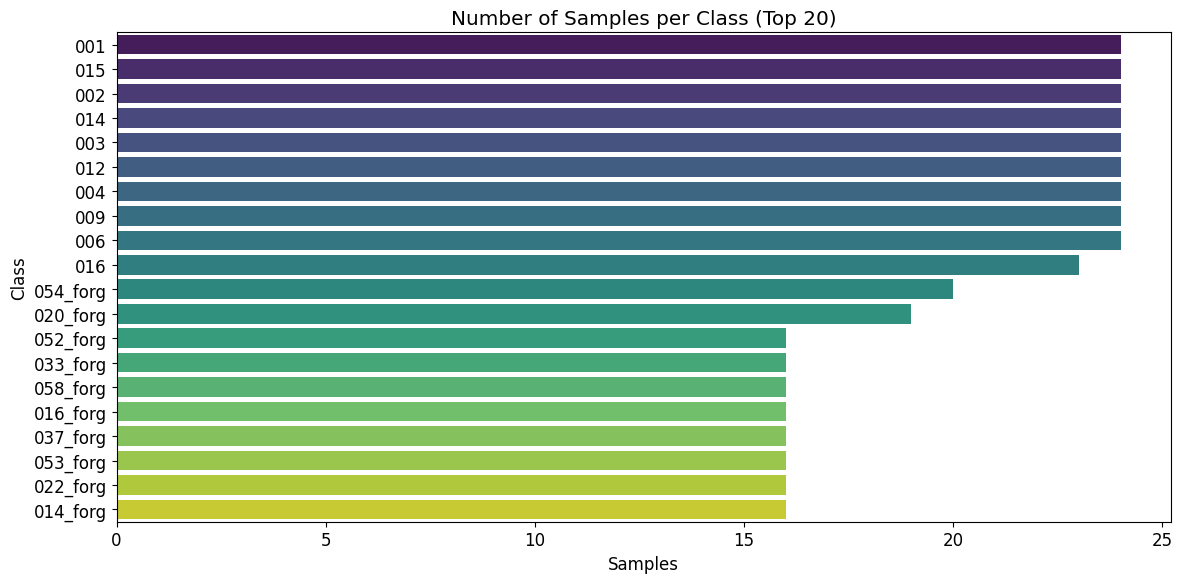

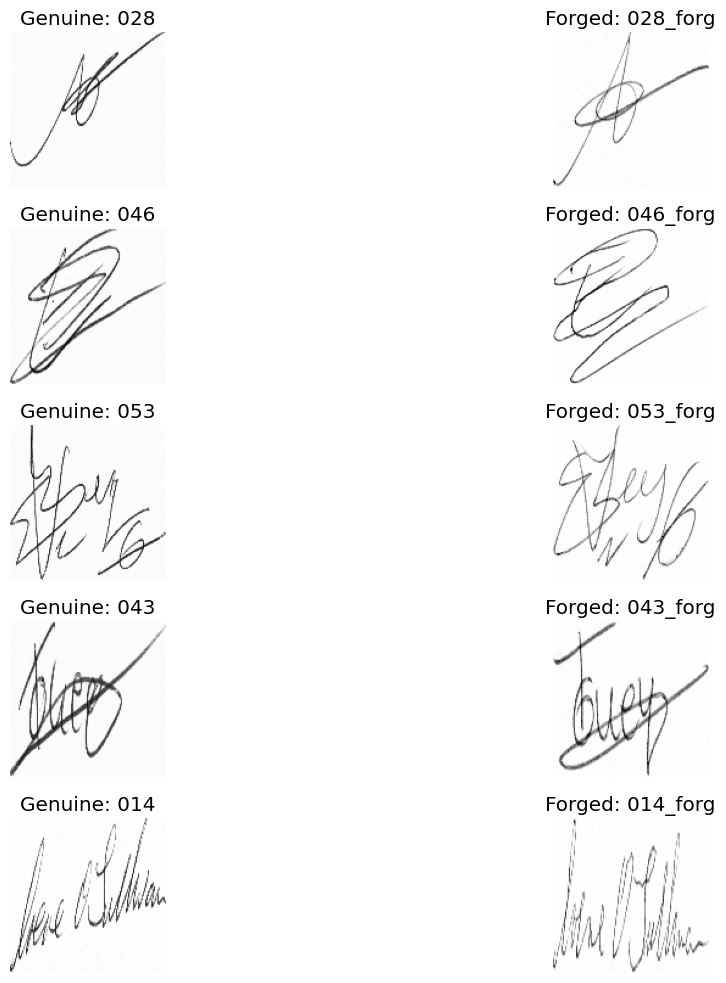


Building CNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          65,664 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,129,824 (65.35 MB)

 Trainable params: 17,129,824 (65.35 MB)

 Non-trainable params: 0 (0.00 B)


Training CNN model...
Compute dtype: float16
Variable dtype: float32


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.0070 - loss: 4.8632

42/42 ━━━━━━━━━━━━━━━━━━━━ 25s 311ms/step - accuracy: 0.0071 - loss: 4.8631 - val_accuracy: 0.0152 - val_loss: 4.8494 - learning_rate: 0.0010
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.0084 - loss: 4.8481 - val_accuracy: 0.0152 - val_loss: 4.8442 - learning_rate: 0.0010
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.0133 - loss: 4.8392 - val_accuracy: 0.0152 - val_loss: 4.8358 - learning_rate: 0.0010
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.0165 - loss: 4.8377 - val_accuracy: 0.0152 - val_loss: 4.8276 - learning_rate: 0.0010
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.0175 - loss: 4.8288 - val_accuracy: 0.0152 - val_loss: 4.8304 - learning_rate: 0.0010
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.0093 - loss: 4.8272 - val_accuracy: 0.0152 - val_loss: 4.8256 - learning_rate: 0.0010
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.0153 - loss: 4.8138 - val_accuracy: 0.

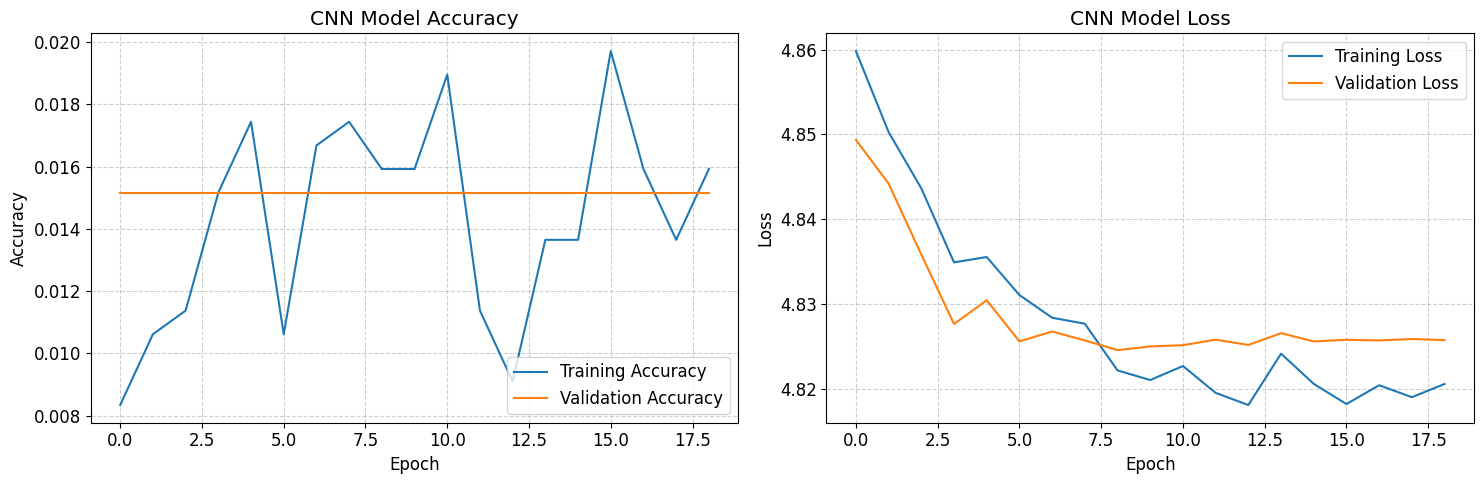


Evaluating CNN model...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0160 - loss: 4.8478
CNN Test Accuracy: 1.52%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step

CNN Classification Report:
              precision    recall  f1-score   support

         001       0.00      0.00      0.00         5
    001_forg       0.00      0.00      0.00         2
         002       0.00      0.00      0.00         5
    002_forg       0.00      0.00      0.00         2
         003       0.00      0.00      0.00         5
    003_forg       0.00      0.00      0.00         3
         004       0.00      0.00      0.00         5
    004_forg       0.00      0.00      0.00         2
         006       0.02      1.00      0.03         5
    006_forg       0.00      0.00      0.00         3
         009       0.00      0.00      0.00         5
    009_forg       0.00      0.00      0.00         2
         012       0.00      0.00      0.00         5
    012_forg       0.00      0.00      0.00        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

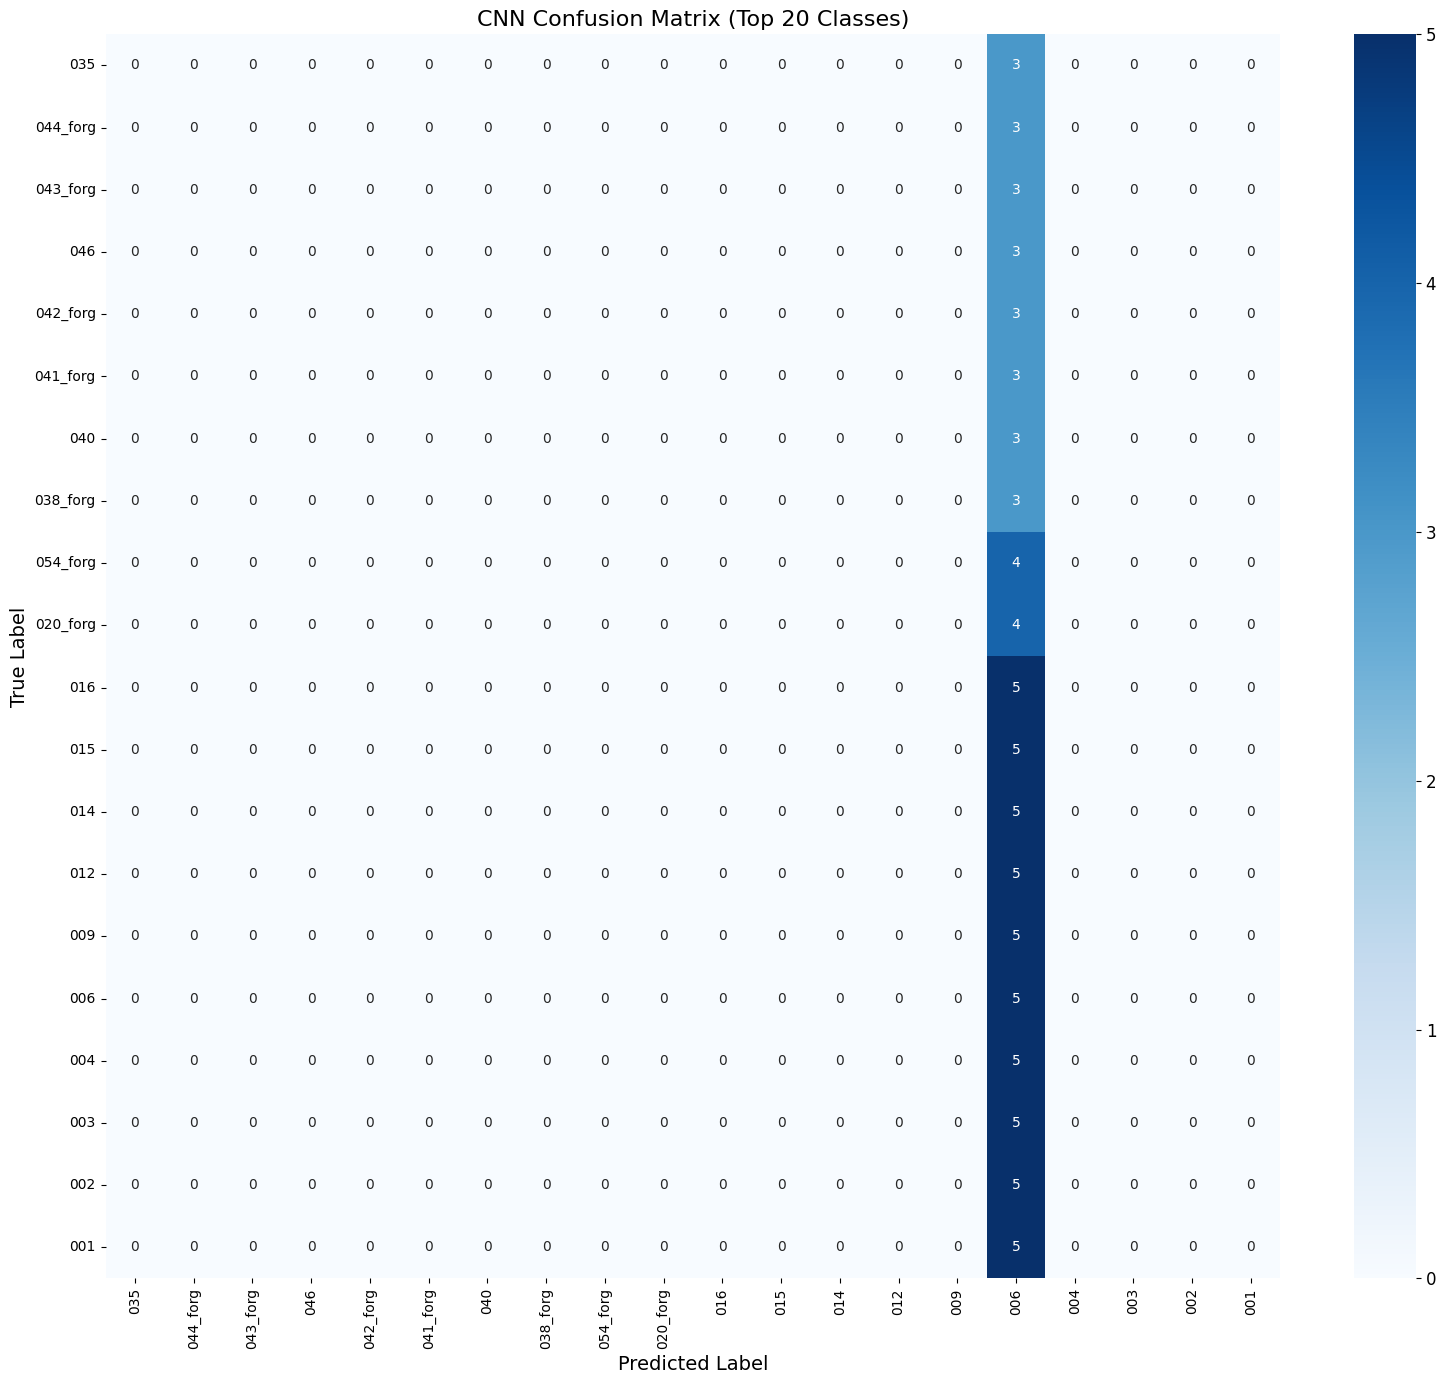


Training HOG+SVM model...


Extracting HOG features: 100%|██████████| 330/330 [00:02<00:00, 125.24image/s]


HOG features extracted. Shape: (1319, 8100)


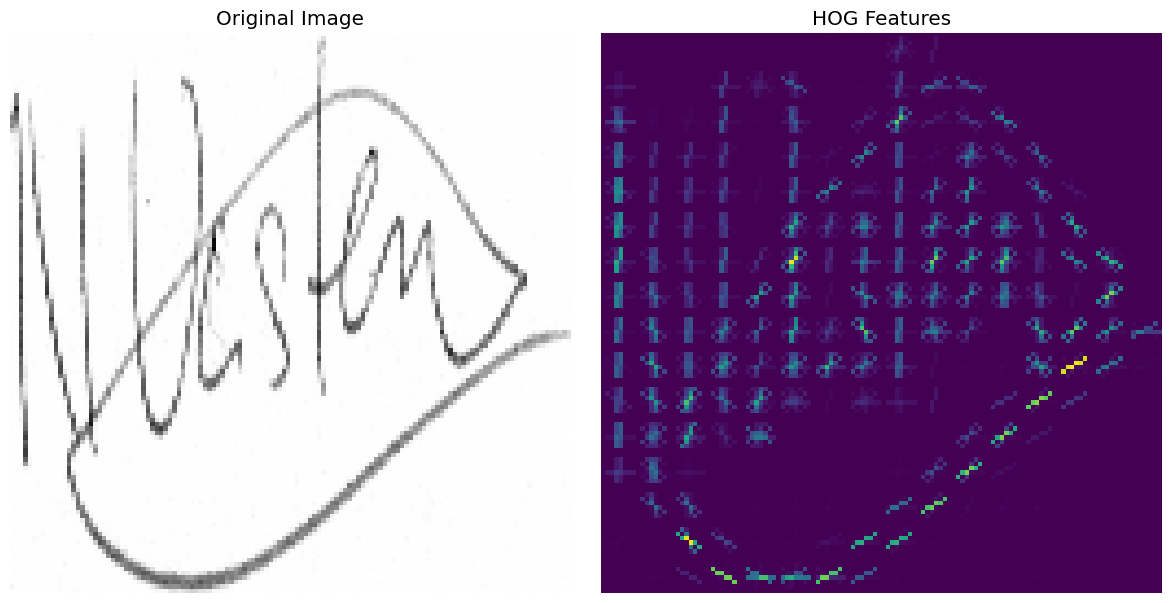

Training SVM with HOG features...
HOG+SVM training completed in 60.97 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

HOG+SVM Accuracy: 78.18%

HOG+SVM Classification Report:
              precision    recall  f1-score   support

         001       1.00      1.00      1.00         5
    001_forg       0.00      0.00      0.00         2
         002       1.00      1.00      1.00         5
    002_forg       1.00      1.00      1.00         2
         003       0.83      1.00      0.91         5
    003_forg       0.50      0.33      0.40         3
         004       1.00      1.00      1.00         5
    004_forg       1.00      1.00      1.00         2
         006       1.00      1.00      1.00         5
    006_forg       0.00      0.00      0.00         3
         009       0.62      1.00      0.77         5
    009_forg       0.00      0.00      0.00         2
         012       0.80      0.80      0.80         5
    012_forg       0.50      0.50      0.50         2
         013       1.00      1.00      1.00         2
    013_forg       1.00      0.50      0.67         2
         014       1.00 

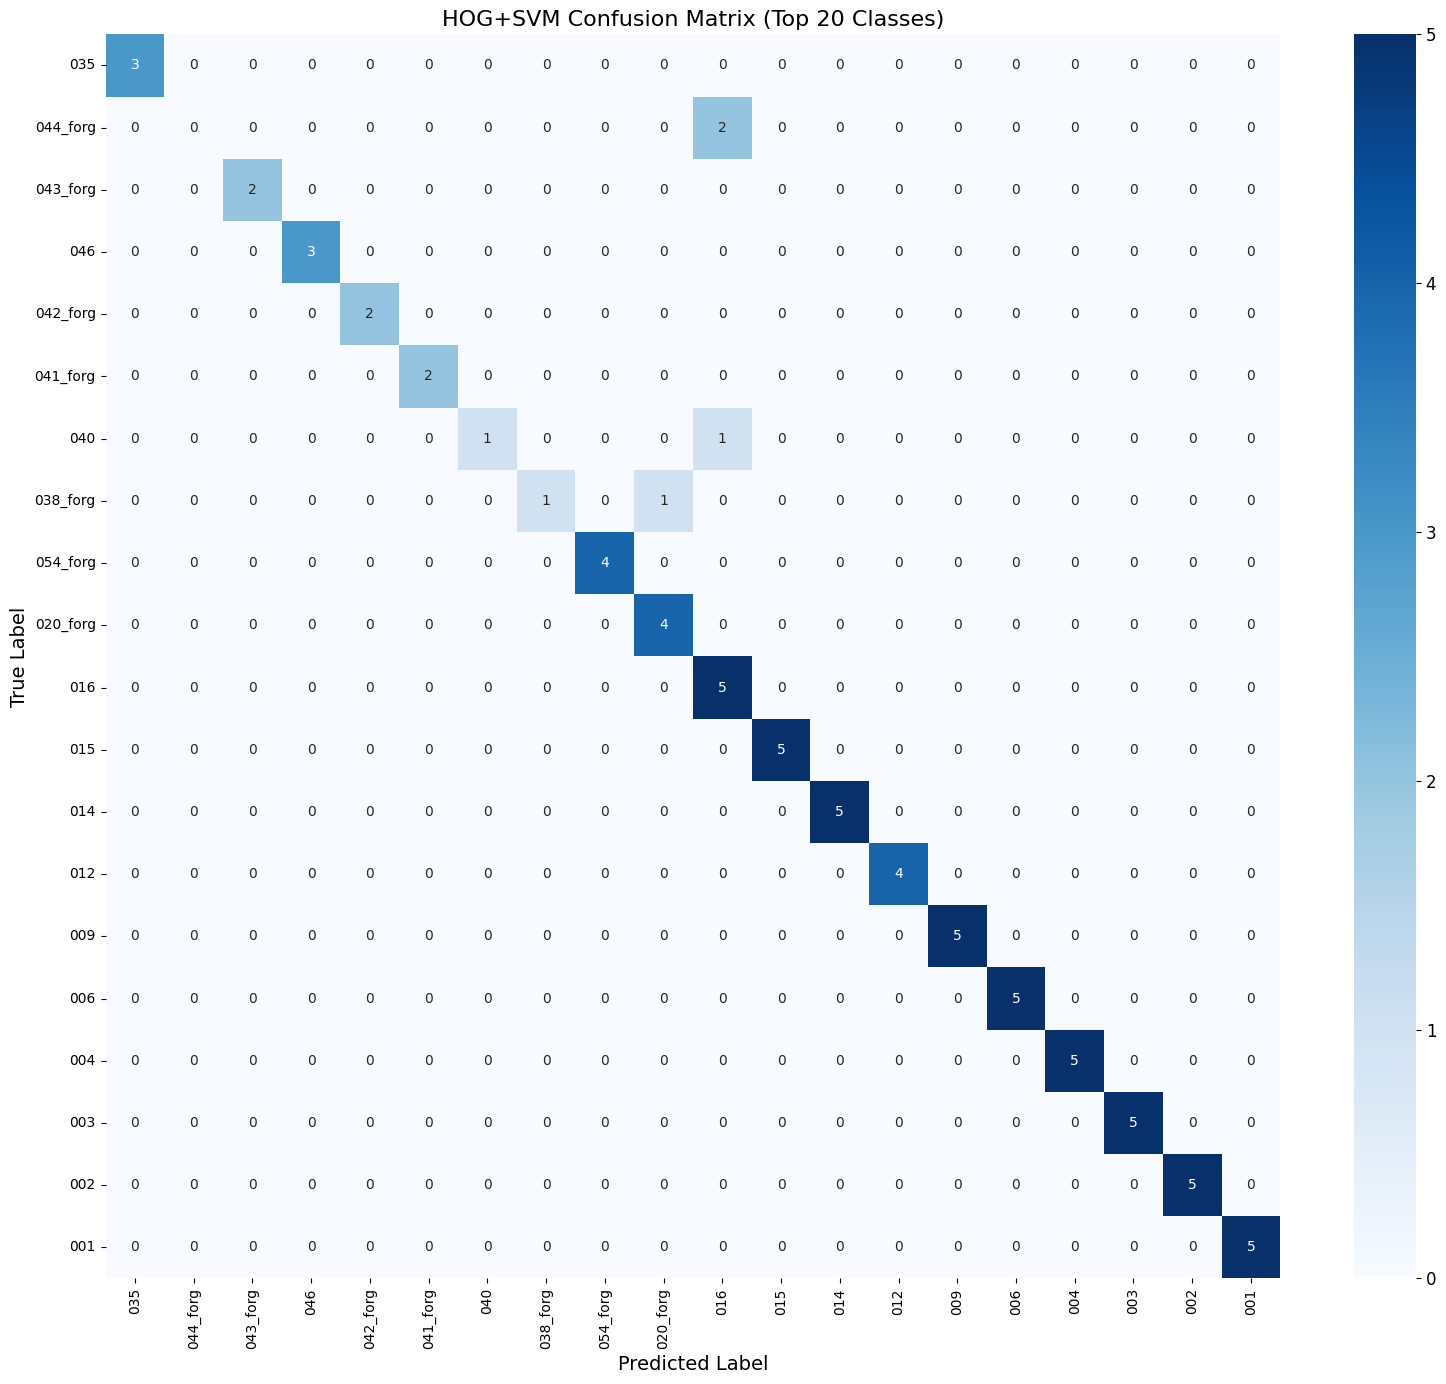

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


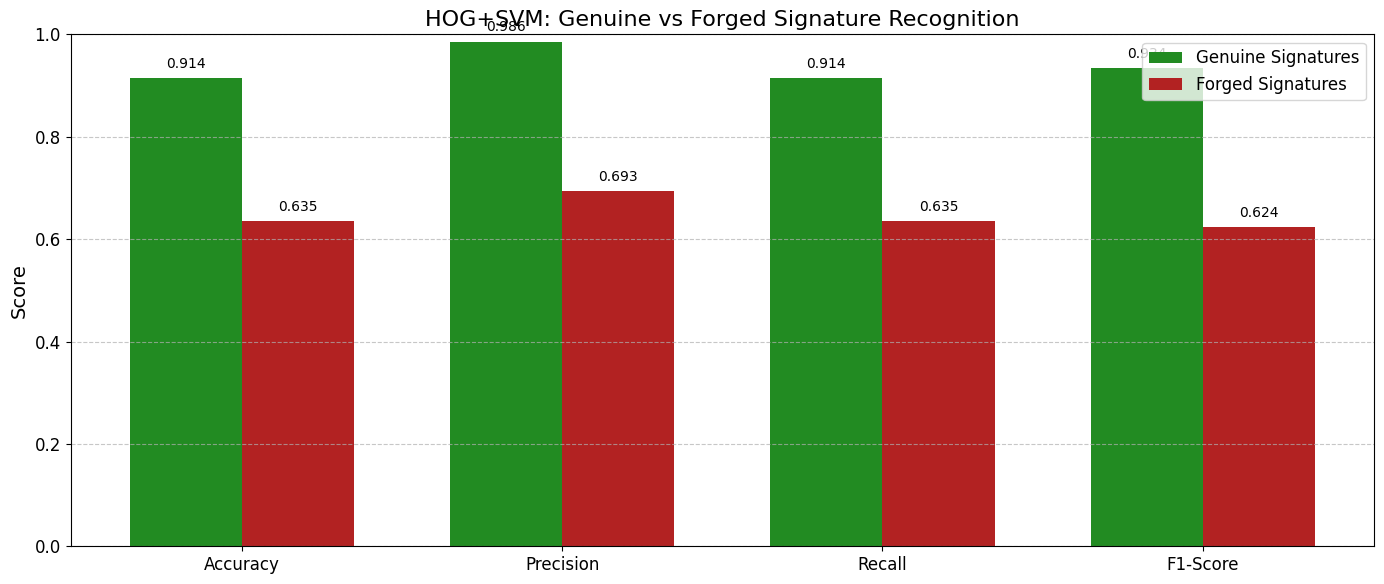


HOG+SVM Genuine vs Forged Performance:
Genuine Signatures: Accuracy=0.9138, F1-Score=0.9342
Forged Signatures: Accuracy=0.6346, F1-Score=0.6237

Training SIFT+SVM model...


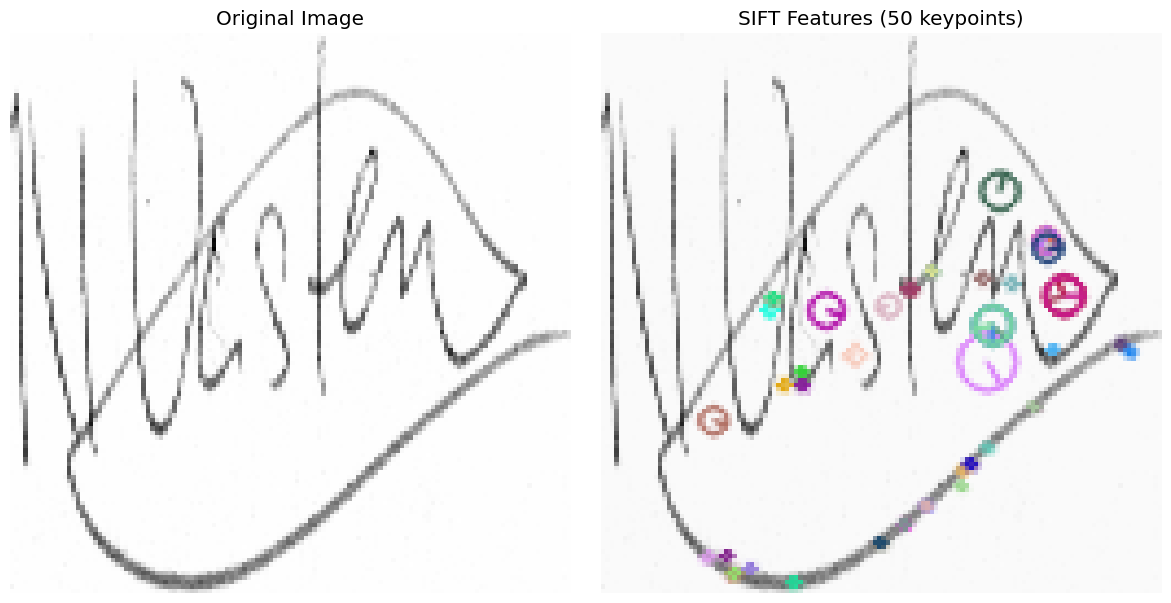

Extracting SIFT keypoints: 100%|██████████| 1319/1319 [00:07<00:00, 181.36image/s]


Creating visual vocabulary with 100 clusters...


Creating SIFT feature vectors: 100%|██████████| 1319/1319 [00:09<00:00, 140.06image/s]


SIFT features extracted. Shape: (1319, 100)


Extracting SIFT keypoints: 100%|██████████| 330/330 [00:01<00:00, 175.88image/s]


Creating visual vocabulary with 100 clusters...


Creating SIFT feature vectors: 100%|██████████| 330/330 [00:02<00:00, 146.59image/s]


Training SVM with SIFT features...
SIFT+SVM training completed in 1.86 seconds
SIFT+SVM Accuracy: 3.33%

SIFT+SVM Classification Report:
              precision    recall  f1-score   support

         001       0.05      1.00      0.09         5
    001_forg       0.00      0.00      0.00         2
         002       0.00      0.00      0.00         5
    002_forg       0.00      0.00      0.00         2
         003       0.10      0.40      0.15         5
    003_forg       0.00      0.00      0.00         3
         004       0.00      0.00      0.00         5
    004_forg       0.00      0.00      0.00         2
         006       0.00      0.00      0.00         5
    006_forg       0.00      0.00      0.00         3
         009       0.05      0.40      0.10         5
    009_forg       0.00      0.00      0.00         2
         012       0.25      0.20      0.22         5
    012_forg       0.00      0.00      0.00         2
         013       0.00      0.00      0.00         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

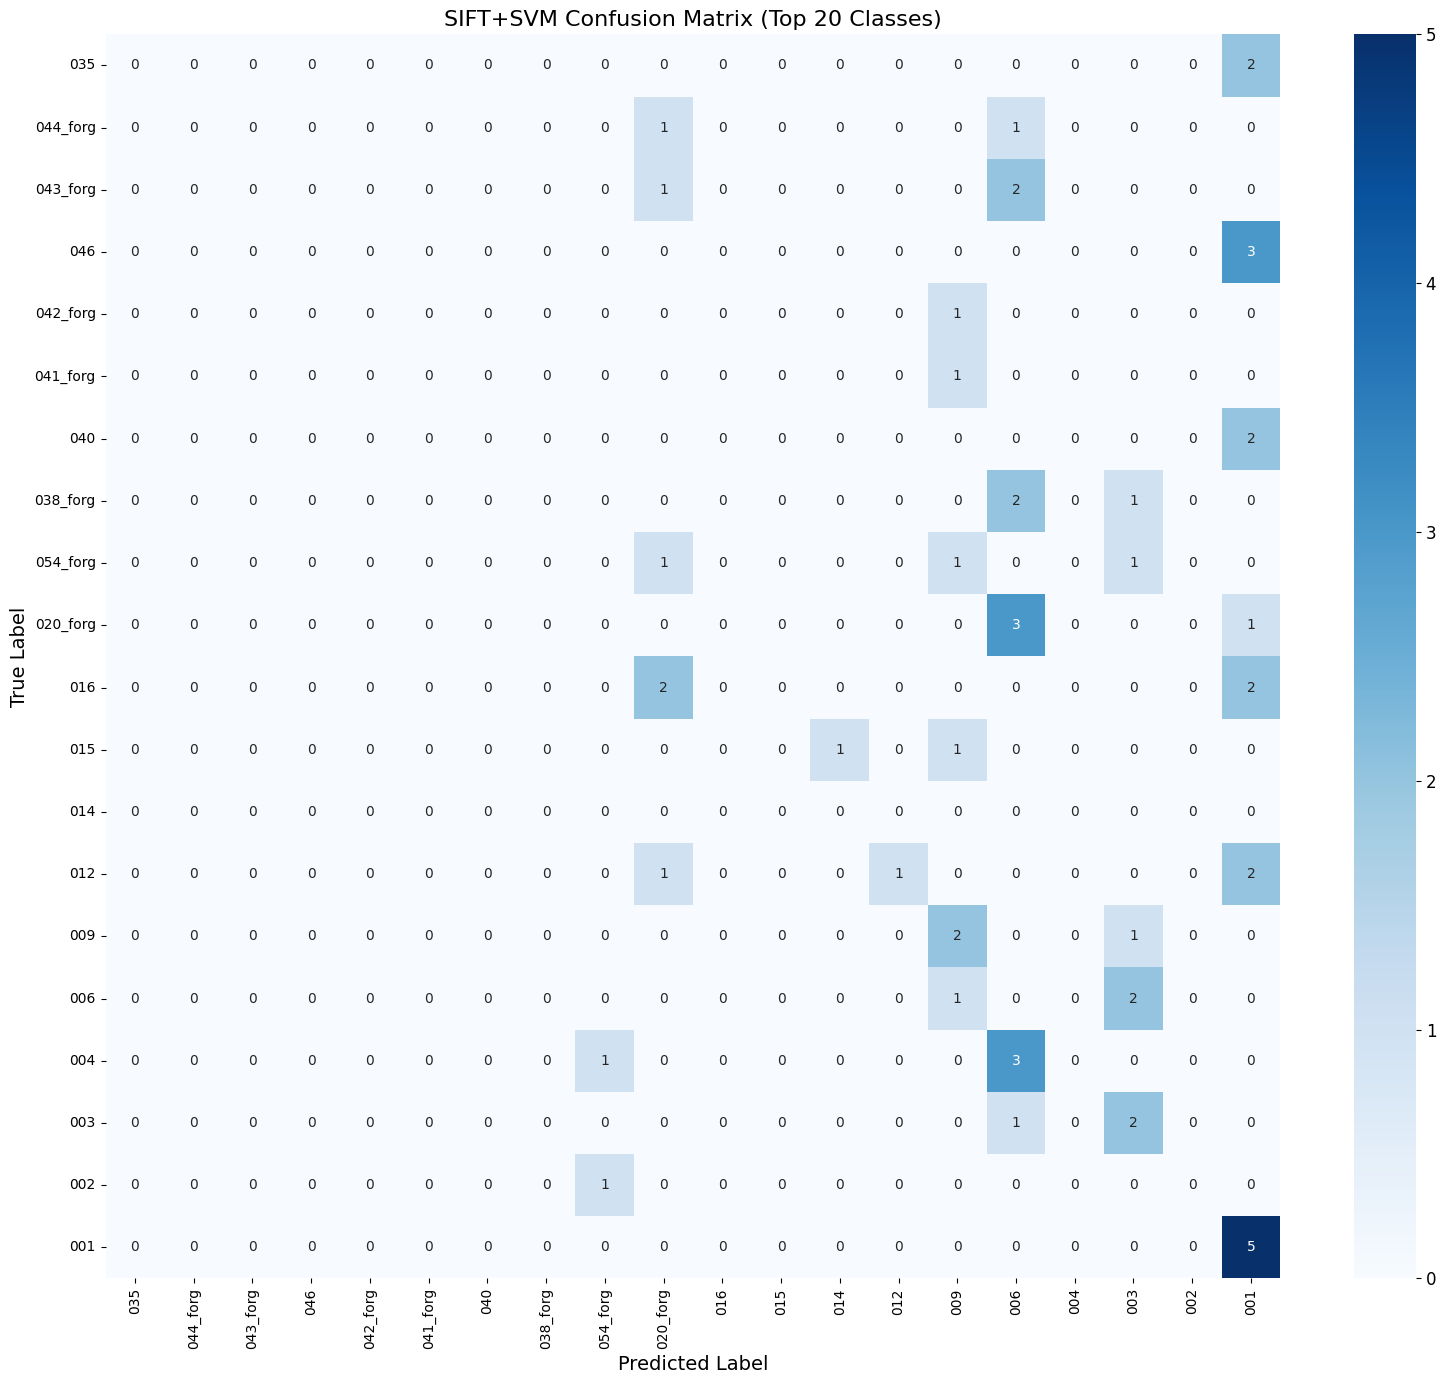


Comparing all methods...

Method Comparison:
  Method  Accuracy  Precision   Recall  F1-Score
     CNN  0.015152   0.000230 0.015152  0.000452
 HOG+SVM  0.781818   0.793677 0.781818  0.757646
SIFT+SVM  0.033333   0.009830 0.033333  0.011601


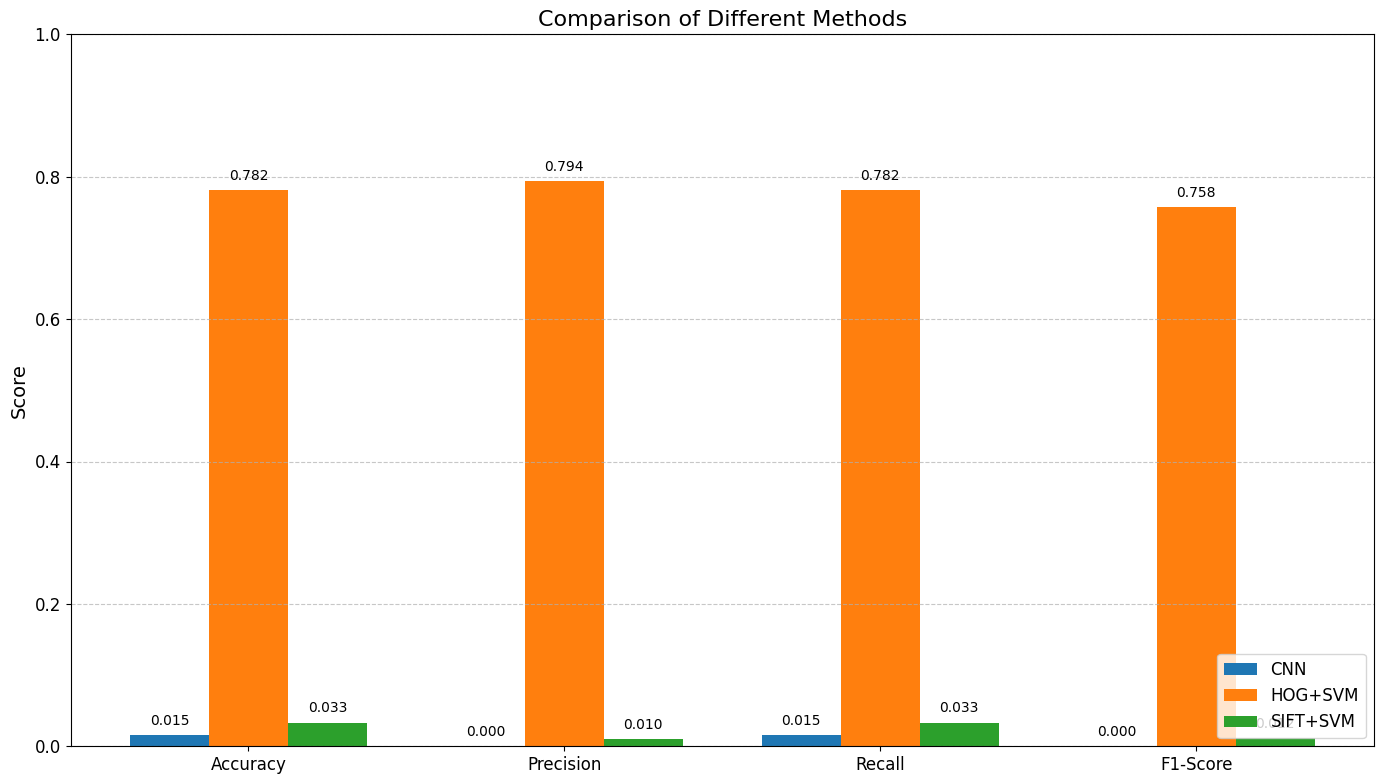


All models saved successfully!


In [10]:
# Run the full pipeline
sig_recognition, comparison = run_signature_recognition(path, epochs=30, show_plots=True)


In [11]:

# Print final results
print("\n" + "="*40)
print("FINAL RESULTS SUMMARY")
print("="*40)
print(comparison.to_string(index=False))
print("\nBest performing method: " + comparison.loc[comparison['Accuracy'].idxmax(), 'Method'])
print("="*40)


FINAL RESULTS SUMMARY
  Method  Accuracy  Precision   Recall  F1-Score
     CNN  0.015152   0.000230 0.015152  0.000452
 HOG+SVM  0.781818   0.793677 0.781818  0.757646
SIFT+SVM  0.033333   0.009830 0.033333  0.011601

Best performing method: HOG+SVM


Models available for testing:
  - CNN: ✓
  - HOG+SVM: ✓
  - SIFT+SVM: ✓

Loading test image: TEST.png


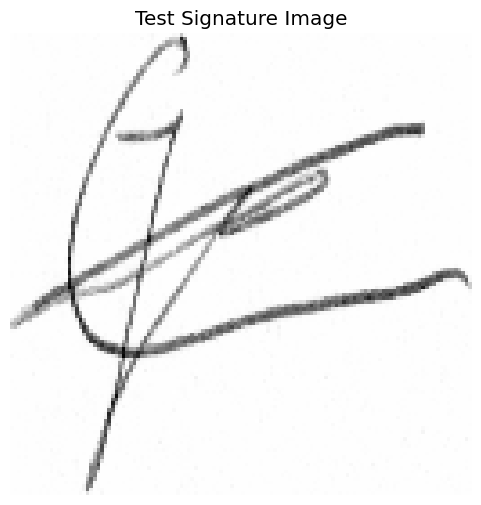


Testing CNN model...


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
CNN Prediction: Class #8 with confidence 0.0142

Testing HOG+SVM model...
HOG+SVM Prediction: Class #91 with confidence 0.7818

SIFT+SVM testing requires the visual vocabulary used during training.
This is typically stored with the model or needs to be recreated from training data.
For a complete implementation, use the SignatureRecognition class.


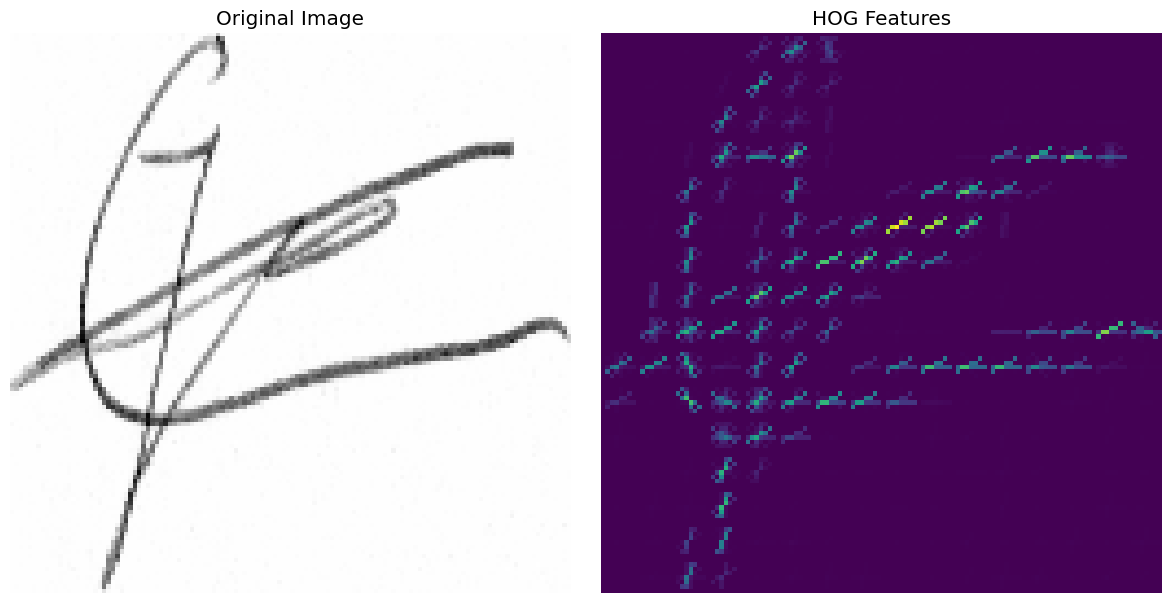

In [13]:
import os
import cv2
import numpy as np
import tensorflow as tf
import joblib
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

def test_signature_recognition(test_image_path, models_dir='.', img_size=(128, 128)):
    """
    Test the signature recognition models on a new image.

    Parameters:
    test_image_path (str): Path to the test signature image
    models_dir (str): Directory containing saved models
    img_size (tuple): Size to resize the image to

    Returns:
    dict: Predictions from each model
    """
    # Check if the test image exists
    if not os.path.exists(test_image_path):
        raise FileNotFoundError(f"Test image not found at {test_image_path}")

    # Check if models exist
    cnn_model_path = os.path.join(models_dir, 'cnn_model.h5')
    hog_model_path = os.path.join(models_dir, 'hog_svm_model.pkl')
    sift_model_path = os.path.join(models_dir, 'sift_svm_model.pkl')

    models_available = {
        'CNN': os.path.exists(cnn_model_path),
        'HOG+SVM': os.path.exists(hog_model_path),
        'SIFT+SVM': os.path.exists(sift_model_path)
    }

    print("Models available for testing:")
    for model, available in models_available.items():
        print(f"  - {model}: {'✓' if available else '✗'}")

    # Load the test image
    print(f"\nLoading test image: {test_image_path}")
    img = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to read image: {test_image_path}")

    # Resize image
    img_resized = cv2.resize(img, img_size)

    # Show the test image
    plt.figure(figsize=(6, 6))
    plt.imshow(img_resized, cmap='gray')
    plt.title('Test Signature Image')
    plt.axis('off')
    plt.show()

    predictions = {}

    # Test CNN model
    if models_available['CNN']:
        print("\nTesting CNN model...")
        try:
            # Load the CNN model
            cnn_model = tf.keras.models.load_model(cnn_model_path)

            # Preprocess the image for CNN
            img_cnn = img_resized / 255.0
            img_cnn = np.expand_dims(img_cnn, axis=0)  # Add batch dimension
            img_cnn = np.expand_dims(img_cnn, axis=-1)  # Add channel dimension

            # Get prediction
            cnn_prediction = cnn_model.predict(img_cnn)
            cnn_class_idx = np.argmax(cnn_prediction[0])
            cnn_confidence = cnn_prediction[0][cnn_class_idx]

            # Since we don't have the class names, we'll use the index
            print(f"CNN Prediction: Class #{cnn_class_idx} with confidence {cnn_confidence:.4f}")
            predictions['CNN'] = {
                'class_idx': int(cnn_class_idx),
                'confidence': float(cnn_confidence)
            }
        except Exception as e:
            print(f"Error testing CNN model: {e}")

    # Test HOG+SVM model
    if models_available['HOG+SVM']:
        print("\nTesting HOG+SVM model...")
        try:
            # Load the HOG+SVM model
            hog_svm_model = joblib.load(hog_model_path)

            # Extract HOG features
            img_normalized = img_resized / 255.0

            # Extract HOG features
            hog_features = hog(img_normalized,
                               orientations=9,
                               pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2),
                               block_norm='L2-Hys',
                               visualize=False)

            hog_features = hog_features.reshape(1, -1)  # Reshape for prediction

            # Get prediction
            hog_class_idx = hog_svm_model.predict(hog_features)[0]
            hog_confidence = np.max(hog_svm_model.predict_proba(hog_features)[0])

            print(f"HOG+SVM Prediction: Class #{hog_class_idx} with confidence {hog_confidence:.4f}")
            predictions['HOG+SVM'] = {
                'class_idx': int(hog_class_idx),
                'confidence': float(hog_confidence)
            }
        except Exception as e:
            print(f"Error testing HOG+SVM model: {e}")

    # Test SIFT+SVM model (more complex, would need the vocabulary)
    # For simplicity, we'll skip implementing this unless the full signature recognition class is available
    if models_available['SIFT+SVM']:
        print("\nSIFT+SVM testing requires the visual vocabulary used during training.")
        print("This is typically stored with the model or needs to be recreated from training data.")
        print("For a complete implementation, use the SignatureRecognition class.")

    return predictions

# Function to visualize HOG features for the test image
def visualize_hog_features(image_path, img_size=(128, 128)):
    """
    Visualize HOG features for a test image

    Parameters:
    image_path (str): Path to the test image
    img_size (tuple): Size to resize the image to
    """
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to read image: {image_path}")

    # Resize image
    img_resized = cv2.resize(img, img_size)

    # Normalize
    img_normalized = img_resized / 255.0

    # Calculate HOG with visualization
    hog_features, hog_image = hog(
        img_normalized,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        block_norm='L2-Hys'
    )

    # Plot
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_normalized, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    # Rescale HOG image for better visibility
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    plt.imshow(hog_image_rescaled, cmap='viridis')
    plt.title('HOG Features')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return hog_features

# Example usage:
if __name__ == "__main__":
    # Set the path to your test image
    test_image_path = "TEST.png"

    # Test the models
    predictions = test_signature_recognition(test_image_path)

    # Visualize HOG features if desired
    try:
        visualize_hog_features(test_image_path)
    except Exception as e:
        print(f"Error visualizing HOG features: {e}")

# **QUESTION NO 2**

In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import kagglehub
from google.colab import drive
import gc


Num GPUs Available:  1
TensorFlow version:  2.18.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path to dataset files: /root/.cache/kagglehub/datasets/kingburrito666/shakespeare-plays/versions/4
Loading and preprocessing CSV file from /root/.cache/kagglehub/datasets/kingburrito666/shakespeare-plays/versions/4/Shakespeare_data.csv...
Loaded 110793 lines from CSV file
Loading and preprocessing TXT file from /root/.cache/kagglehub/datasets/kingburrito666/shakespeare-plays/versions/4/alllines.txt...
Loaded 111396 lines from TXT file
Total words in dataset: 1661086
Unique words in dataset: 49662
Vocabulary size after filtering rare words: 49574
Tokenizing the text...
Final vocabulary size: 22586
Creating sequences with length 8...
Building the model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Processing sequences and training the model in batches...
Processing batch 1 with 100000 sequences
Training sequences: 90000
Validation sequences: 10000
Training on batch 1...
Epoch 1/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0320 - loss: 7.4183
Epoch 1: val_accuracy improved from -inf to 0.03840, saving model to /content/drive/MyDrive/shakespeare_model/best_model.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.0320 - loss: 7.4170 - val_accuracy: 0.0384 - val_loss: 6.6829 - learning_rate: 0.0010
Epoch 2/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0420 - loss: 6.5538
Epoch 2: val_accuracy improved from 0.03840 to 0.04550, saving model to /content/drive/MyDrive/shakespeare_model/best_model.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.0420 - loss: 6.5538 - val_accuracy: 0.0455 - val_loss: 6.6301 - learning_rate: 0.0010
Epoch 3/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0490 - loss: 6.4133
Epoch

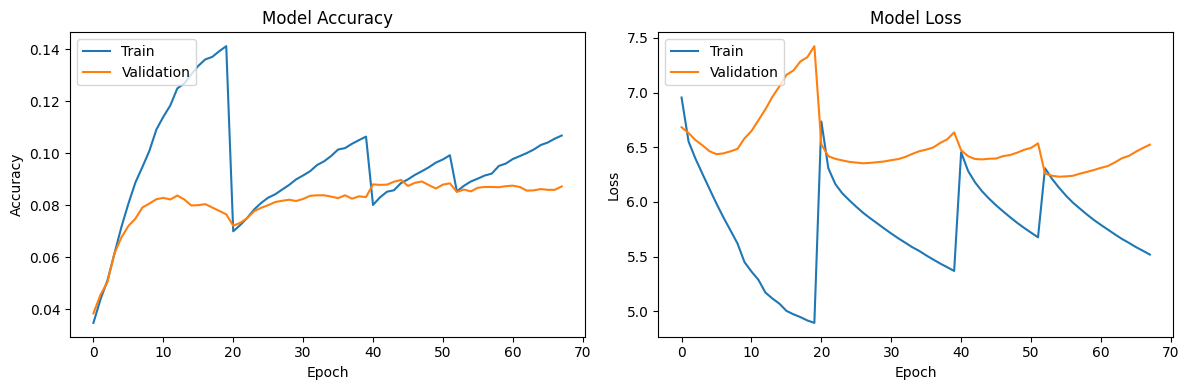


Testing the model with some prompts...

Prompt: 'to be or not to'
Top 5 predicted next words:
1. 'be' (confidence: 17.46%)
2. 'the' (confidence: 11.46%)
3. 'make' (confidence: 3.30%)
4. 'do' (confidence: 3.09%)
5. 'have' (confidence: 2.33%)
Completed sentence: 'to be or not to be'
Extended sentence: 'to be or not to do your malice but you have so comfort'

Prompt: 'all the world's a'
Top 5 predicted next words:
1. 'king' (confidence: 5.64%)
2. 'man' (confidence: 1.92%)
3. 'world' (confidence: 1.87%)
4. 'duke' (confidence: 1.20%)
5. 'great' (confidence: 0.93%)
Completed sentence: 'all the world's a king'
Extended sentence: 'all the world's a stocks was loved him in all return on'

Prompt: 'friends romans countrymen lend me'
Top 5 predicted next words:
1. 'the' (confidence: 15.73%)
2. 'a' (confidence: 4.24%)
3. 'to' (confidence: 3.99%)
4. 'my' (confidence: 3.69%)
5. 'i' (confidence: 3.50%)
Completed sentence: 'friends romans countrymen lend me the'
Extended sentence: 'friends romans cou

In [4]:

# Check if TensorFlow can see the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version: ", tf.__version__)

# Mount Google Drive for saving models
drive.mount('/content/drive')

# Download the dataset using kagglehub
def download_dataset():
    try:
        print("Downloading dataset using kagglehub...")
        path = kagglehub.dataset_download("kingburrito666/shakespeare-plays")
        print("Path to dataset files:", path)
        return path
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        return None

# Improved data loading and preprocessing with better text cleaning
def load_and_preprocess_csv(file_path):
    try:
        data = pd.read_csv(file_path)
        text_data = data.iloc[:, 5].dropna().astype(str).tolist()

        cleaned_text = []
        for line in text_data:
            # Skip stage directions enclosed in square brackets
            if not line.startswith('[') and not line.endswith(']'):
                # Better cleaning while preserving important punctuation and structure
                clean_line = re.sub(r'[^\w\s.,!?;:\-]', ' ', line.lower())
                # Remove extra spaces
                clean_line = re.sub(r'\s+', ' ', clean_line).strip()
                if clean_line:
                    cleaned_text.append(clean_line)

        return cleaned_text
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        return []

def load_and_preprocess_txt(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()

        cleaned_text = []
        for line in lines:
            if line.strip():
                clean_line = re.sub(r'[^\w\s.,!?;:\-]', ' ', line.strip().lower())
                clean_line = re.sub(r'\s+', ' ', clean_line).strip()
                if clean_line:
                    cleaned_text.append(clean_line)

        return cleaned_text
    except Exception as e:
        print(f"Error loading TXT file: {e}")
        return []

def create_sequences(tokenized_text, sequence_length, max_sequences=None, stride=1):
    input_sequences = []
    target_words = []

    # If max_sequences is not None, limit the number of sequences
    end_range = len(tokenized_text) - sequence_length
    if max_sequences is not None:
        end_range = min(end_range, max_sequences * stride)

    # Use stride for data augmentation (creating more training examples)
    for i in range(0, end_range, stride):
        input_sequence = tokenized_text[i:i+sequence_length]
        target_word = tokenized_text[i+sequence_length]

        # Skip sequences with unknown tokens as targets
        if target_word != 1:  # Assuming 1 is the index for <UNK>
            input_sequences.append(input_sequence)
            target_words.append(target_word)

        # Periodically yield sequences to avoid memory issues
        if len(input_sequences) >= 100000 or i >= end_range - stride:
            if input_sequences:
                yield np.array(input_sequences), np.array(target_words)
                input_sequences = []
                target_words = []
                gc.collect()

def main():
    dataset_path = download_dataset()

    if not dataset_path:
        print("Failed to download dataset. Please upload files manually.")
        from google.colab import files
        uploaded = files.upload()
        dataset_path = "."

    csv_path = os.path.join(dataset_path, "Shakespeare_data.csv")
    txt_path = os.path.join(dataset_path, "alllines.txt")

    # Check if files exist
    csv_exists = os.path.exists(csv_path)
    txt_exists = os.path.exists(txt_path)

    if not csv_exists:
        print(f"CSV file not found at {csv_path}")
        csv_path = "Shakespeare_data.csv"
        csv_exists = os.path.exists(csv_path)

    if not txt_exists:
        print(f"TXT file not found at {txt_path}")
        txt_path = "alllines.txt"
        txt_exists = os.path.exists(txt_path)

    all_text_data = []

    if csv_exists:
        print(f"Loading and preprocessing CSV file from {csv_path}...")
        csv_data = load_and_preprocess_csv(csv_path)
        all_text_data.extend(csv_data)
        print(f"Loaded {len(csv_data)} lines from CSV file")

    if txt_exists:
        print(f"Loading and preprocessing TXT file from {txt_path}...")
        txt_data = load_and_preprocess_txt(txt_path)
        all_text_data.extend(txt_data)
        print(f"Loaded {len(txt_data)} lines from TXT file")

    if not all_text_data:
        print("No data loaded. Please check file paths and try again.")
        return

    # Join all lines into a single text for tokenization
    all_text = ' '.join(all_text_data)
    words = all_text.split()
    print(f"Total words in dataset: {len(words)}")
    print(f"Unique words in dataset: {len(set(words))}")

    # Filter out rare words but keep more of Shakespeare's vocabulary
    word_counts = {}
    for word in words:
        word_counts[word] = word_counts.get(word, 0) + 1

    # Keep only words that appear at least 2 times (reduced from 3)
    common_words = {word for word, count in word_counts.items() if count >= 2}
    print(f"Vocabulary size after filtering rare words: {len(common_words)}")

    # Add important specialized Shakespeare words back in
    shakespeare_specific = ['thee', 'thou', 'thy', 'thine', 'hath', 'doth', 'art', 'wilt',
                           'forsooth', 'methinks', 'wherefore', 'whence', 'whilst', 'anon',
                           'ere', 'tis', 'twas', 'alas', 'perchance', 'fie', 'lo', 'hark',
                           'nay', 'mayhap', 'prithee', 'thence', 'betwixt', 'beseech',
                           'dost', 'hast', 'canst', 'didst', 'wouldst', 'twere', 'ope',
                           'oft', 'tho', 'mayst', 'ay', 'adieu', 'hie', 'yond', 'durst',
                           'deem', 'whereat', 'behold', 'fain', 'aye', 'neer', 'oer',
                           'yea', 'marry', 'sirrah', 'certes', 'enow', 'tarry', 'stage',
                           'discontent', 'love', 'mercy', 'strained']

    for word in shakespeare_specific:
        common_words.add(word)

    # Clear word_counts to free memory
    del word_counts
    gc.collect()

    print("Tokenizing the text...")
    tokenizer = Tokenizer(oov_token="<UNK>")
    tokenizer.fit_on_texts([' '.join(common_words)])
    total_words = len(tokenizer.word_index) + 1
    print(f"Final vocabulary size: {total_words}")

    # Convert text to sequences of token indices
    tokenized_text = tokenizer.texts_to_sequences([all_text])[0]

    # Clear memory
    del all_text, words, common_words
    gc.collect()

    # Create input sequences and target words
    sequence_length = 8
    print(f"Creating sequences with length {sequence_length}...")

    print("Building the model...")
    model = Sequential([
        Embedding(total_words, 200, input_length=sequence_length),
        Bidirectional(LSTM(256, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(192, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(128)),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(total_words, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    print(model.summary())

    save_dir = "/content/drive/MyDrive/shakespeare_model"
    os.makedirs(save_dir, exist_ok=True)

    checkpoint_path = os.path.join(save_dir, "best_model.weights.h5")

    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.0001,
        verbose=1
    )

    # Use generator to create sequences in batches and train model
    print("Processing sequences and training the model in batches...")

    # Process more sequences with stride for data augmentation
    MAX_SEQUENCES = 1000000
    STRIDE = 1

    sequence_generator = create_sequences(tokenized_text, sequence_length, MAX_SEQUENCES, STRIDE)

    batch_size = 256
    epochs = 25

    # Training history
    all_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    # Process multiple batches of sequences instead of just one
    for batch_num, (X_batch, y_batch) in enumerate(sequence_generator):
        print(f"Processing batch {batch_num+1} with {len(X_batch)} sequences")

        # Split into training and validation sets (90-10 split)
        split_index = int(len(X_batch) * 0.9)
        X_train, X_val = X_batch[:split_index], X_batch[split_index:]
        y_train, y_val = y_batch[:split_index], y_batch[split_index:]

        print(f"Training sequences: {X_train.shape[0]}")
        print(f"Validation sequences: {X_val.shape[0]}")

        # Train on this batch
        print(f"Training on batch {batch_num+1}...")
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=[checkpoint_callback, early_stopping, reduce_lr]
        )

        # Append history
        for metric in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
            all_history[metric].extend(history.history[metric])

        # Process 4 batches for even better training
        if batch_num >= 3:
            break

    # Save the full model and tokenizer
    model_save_path = os.path.join(save_dir, "shakespeare_word_model.keras")
    tokenizer_save_path = os.path.join(save_dir, "tokenizer.pickle")

    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")

    import pickle
    with open(tokenizer_save_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Tokenizer saved to {tokenizer_save_path}")

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(all_history['accuracy'])
    plt.plot(all_history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(all_history['loss'])
    plt.plot(all_history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_history.png'))
    plt.show()

    # Test the model on some example inputs
    test_model(model, tokenizer, sequence_length, total_words)

def test_model(model, tokenizer, sequence_length, total_words, temperature=0.8):
    print("\nTesting the model with some prompts...")

    test_prompts = [
        "to be or not to",
        "all the world's a",
        "friends romans countrymen lend me",
        "now is the winter of our",
        "if music be the food of",
        "the quality of mercy is",
        "to sleep perchance to dream",
        "alas poor yorick i knew him",
        "romeo romeo wherefore art thou",
        "shall i compare thee to"
    ]

    index_to_word = {v: k for k, v in tokenizer.word_index.items()}
    unk_token_id = tokenizer.word_index.get("<UNK>", 1)

    for prompt in test_prompts:
        # Tokenize the prompt
        prompt_words = prompt.lower().split()

        # Handle case where prompt is shorter than sequence_length
        if len(prompt_words) < sequence_length:
            padding_needed = sequence_length - len(prompt_words)
            # Pad with zeros at the beginning
            token_list = [0] * padding_needed
            # Add the actual tokens
            for word in prompt_words:
                if word in tokenizer.word_index:
                    token_list.append(tokenizer.word_index[word])
                else:
                    token_list.append(unk_token_id)
        else:
            # Get the last 'sequence_length' words
            recent_words = prompt_words[-sequence_length:]
            token_list = []
            for word in recent_words:
                if word in tokenizer.word_index:
                    token_list.append(tokenizer.word_index[word])
                else:
                    token_list.append(unk_token_id)

        # Reshape for prediction
        token_list = np.array([token_list])

        # Predict
        predictions = model.predict(token_list, verbose=0)[0]

        # Apply temperature scaling for more diverse predictions
        if temperature != 1.0:
            predictions = np.log(predictions + 1e-10) / temperature
            predictions = np.exp(predictions)
            predictions = predictions / np.sum(predictions)

        # Get top 20 predictions
        top_indices = np.argsort(predictions)[-20:][::-1]

        # Filter out UNK token and padding
        filtered_indices = [idx for idx in top_indices if idx != unk_token_id and idx != 0][:10]

        # If we have less than 5 predictions after filtering, add some more from top_indices
        while len(filtered_indices) < 5 and len(filtered_indices) < len(top_indices):
            for idx in top_indices:
                if idx not in filtered_indices and idx != 0:  # Skip padding
                    filtered_indices.append(idx)
                    break

        # Take only top 5
        filtered_indices = filtered_indices[:5]

        print(f"\nPrompt: '{prompt}'")
        print("Top 5 predicted next words:")

        for i, idx in enumerate(filtered_indices):
            predicted_word = index_to_word.get(idx, "<RARE>")
            probability = predictions[idx] * 100
            print(f"{i+1}. '{predicted_word}' (confidence: {probability:.2f}%)")

        if filtered_indices:
            best_word = index_to_word.get(filtered_indices[0], "<RARE>")
            print(f"Completed sentence: '{prompt} {best_word}'")
        else:
            print(f"Completed sentence: '{prompt} [no valid prediction]'")

        # Generate a few more words to show continuity
        full_sentence = prompt.split()
        for _ in range(8):  # Generate 8 more words
            current_sequence = []
            if len(full_sentence) < sequence_length:
                # Pad with zeros
                current_sequence = [0] * (sequence_length - len(full_sentence))
                for word in full_sentence:
                    if word in tokenizer.word_index:
                        current_sequence.append(tokenizer.word_index[word])
                    else:
                        current_sequence.append(unk_token_id)
            else:
                # Use last sequence_length words
                for word in full_sentence[-sequence_length:]:
                    if word in tokenizer.word_index:
                        current_sequence.append(tokenizer.word_index[word])
                    else:
                        current_sequence.append(unk_token_id)

            # Predict next word
            predicted = model.predict(np.array([current_sequence]), verbose=0)[0]

            # Apply temperature scaling
            if temperature != 1.0:
                predicted = np.log(predicted + 1e-10) / temperature
                predicted = np.exp(predicted)
                predicted = predicted / np.sum(predicted)

            # Remove UNK from possibilities
            predicted[unk_token_id] = 0
            predicted[0] = 0  # Remove padding token too

            # Normalize probabilities after removing UNK
            if np.sum(predicted) > 0:
                predicted = predicted / np.sum(predicted)

                # Sample from the distribution instead of just taking the argmax
                next_index = np.random.choice(len(predicted), p=predicted)
                next_word = index_to_word.get(next_index, "the")  # Fallback to common word if needed
            else:
                # If no valid predictions (unlikely), use a common word
                common_words = ["the", "and", "of", "to", "a", "in", "that", "is"]
                next_word = np.random.choice(common_words)

            full_sentence.append(next_word)

        print(f"Extended sentence: '{' '.join(full_sentence)}'")

if __name__ == "__main__":
    main()

**FRONTEND**

In [5]:

import tensorflow as tf
import numpy as np
import pickle
import os
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from google.colab import output

# Load the trained model and tokenizer
def load_model_and_tokenizer():
    model_path = "/content/drive/MyDrive/shakespeare_model/shakespeare_word_model.keras"
    tokenizer_path = "/content/drive/MyDrive/shakespeare_model/tokenizer.pickle"

    try:
        model = tf.keras.models.load_model(model_path)
        print(f"Model loaded from {model_path}")

        with open(tokenizer_path, 'rb') as handle:
            tokenizer = pickle.load(handle)
        print(f"Tokenizer loaded from {tokenizer_path}")

        return model, tokenizer
    except Exception as e:
        print(f"Error loading model or tokenizer: {e}")
        return None, None

# Prediction function
def predict_next_words(model, tokenizer, text_input, sequence_length=8, num_words=1, temperature=0.8, top_k=5):
    """Generate predictions for the next words after the input text."""
    unk_token_id = tokenizer.word_index.get("<UNK>", 1)

    # Convert tokens to word indices
    input_text = text_input.lower().strip()
    input_words = input_text.split()

    # Initialize predicted words list
    predicted_words = []

    for _ in range(num_words):
        # Get current input
        current_words = input_words[-sequence_length:] if len(input_words) >= sequence_length else input_words

        # Handle case where input is shorter than sequence_length
        if len(current_words) < sequence_length:
            padding_needed = sequence_length - len(current_words)
            token_list = [0] * padding_needed  # Pad with zeros

            # Add actual tokens
            for word in current_words:
                if word in tokenizer.word_index:
                    token_list.append(tokenizer.word_index[word])
                else:
                    token_list.append(unk_token_id)
        else:
            # Get the last sequence_length words
            token_list = []
            for word in current_words:
                if word in tokenizer.word_index:
                    token_list.append(tokenizer.word_index[word])
                else:
                    token_list.append(unk_token_id)

        # Reshape for prediction
        token_list = np.array([token_list])

        predictions = model.predict(token_list, verbose=0)[0]

        # Apply temperature scaling
        if temperature != 1.0:
            predictions = np.log(predictions + 1e-10) / temperature
            predictions = np.exp(predictions)
            predictions = predictions / np.sum(predictions)

        # Set UNK and padding token probabilities to 0
        predictions[unk_token_id] = 0
        predictions[0] = 0

        # Normalize probabilities after removing UNK and padding
        if np.sum(predictions) > 0:
            predictions = predictions / np.sum(predictions)

        # Get top-k indices and their probabilities
        top_indices = np.argsort(predictions)[-top_k:][::-1]
        index_to_word = {v: k for k, v in tokenizer.word_index.items()}

        # Get the next word (choosing the top one)
        if len(top_indices) > 0:
            next_index = top_indices[0]
            next_word = index_to_word.get(next_index, "the")

            # Add to predicted words and input_words
            predicted_words.append(next_word)
            input_words.append(next_word)

        # Get top-k predictions with probabilities
        top_predictions = []
        for idx in top_indices:
            if idx > 0:  # Skip padding token
                word = index_to_word.get(idx, "RARE")
                prob = predictions[idx] * 100
                top_predictions.append((word, prob))

    return predicted_words, top_predictions

# Create a styled interface with HTML/CSS
def create_shakespeare_interface():
    # Load model and tokenizer
    model, tokenizer = load_model_and_tokenizer()
    if model is None or tokenizer is None:
        return

    # CSS for styling
    css = """
    <style>
    .shakespeare-app {
        max-width: 800px;
        margin: 0 auto;
        padding: 20px;
        font-family: 'Georgia', serif;
        background-color: #f9f7f1;
        border-radius: 8px;
        box-shadow: 0 4px 8px rgba(0,0,0,0.1);
    }
    .shakespeare-header {
        text-align: center;
        margin-bottom: 20px;
        border-bottom: 2px solid #8b4513;
        padding-bottom: 15px;
    }
    .shakespeare-title {
        font-size: 28px;
        color: #8b4513;
        margin-bottom: 10px;
    }
    .input-container {
        margin-bottom: 20px;
    }
    .prediction-container {
        margin-top: 20px;
        padding: 15px;
        background-color: #fff;
        border-radius: 5px;
        border: 1px solid #ddd;
    }
    .prediction-title {
        font-weight: bold;
        margin-bottom: 10px;
        color: #8b4513;
    }
    .prediction-word {
        font-weight: bold;
        color: #8b4513;
    }
    .prob-container {
        display: flex;
        margin-bottom: 5px;
    }
    .prob-word {
        width: 120px;
        font-weight: bold;
    }
    .prob-bar {
        flex-grow: 1;
        height: 20px;
        background-color: #e9e3d3;
        position: relative;
        border-radius: 3px;
        overflow: hidden;
    }
    .prob-bar-fill {
        height: 100%;
        background-color: #8b4513;
    }
    .prob-value {
        position: absolute;
        right: 5px;
        top: 2px;
        color: #fff;
        font-size: 12px;
    }
    .completion {
        font-style: italic;
        margin-top: 15px;
        line-height: 1.5;
    }
    .completion-word {
        color: #8b4513;
        font-weight: bold;
    }
    .params-container {
        display: flex;
        justify-content: space-between;
        margin: 15px 0;
    }
    .param-group {
        width: 48%;
    }
    </style>
    """

    # Create input text widget
    text_input = widgets.Textarea(
        value='To be or not to',
        placeholder='Enter your text here...',
        description='Text:',
        layout=widgets.Layout(width='100%', height='100px')
    )

    # Create parameter widgets
    temp_slider = widgets.FloatSlider(
        value=0.8,
        min=0.1,
        max=1.5,
        step=0.1,
        description='Temperature:',
        layout=widgets.Layout(width='90%')
    )

    words_slider = widgets.IntSlider(
        value=5,
        min=1,
        max=20,
        step=1,
        description='Words to generate:',
        layout=widgets.Layout(width='90%')
    )

    # Create prediction button
    predict_button = widgets.Button(
        description='Predict Next Words',
        button_style='primary',
        layout=widgets.Layout(width='100%', height='40px')
    )

    # Examples dropdown
    examples = [
        'To be or not to',
        'All the world\'s a',
        'Friends Romans countrymen lend me',
        'Now is the winter of our',
        'If music be the food of',
        'The quality of mercy is',
        'Romeo Romeo wherefore art thou',
        'Shall I compare thee to'
    ]
    example_dropdown = widgets.Dropdown(
        options=examples,
        value=examples[0],
        description='Examples:',
        layout=widgets.Layout(width='100%')
    )

    # Output widget for predictions
    output_widget = widgets.Output()

    # Function to handle example selection
    def on_example_select(change):
        text_input.value = change['new']

    # Function to handle prediction button click
    def on_button_clicked(b):
        with output_widget:
            clear_output()

            if not text_input.value.strip():
                print("Please enter some text")
                return

            # Get parameters
            temperature = temp_slider.value
            num_words = words_slider.value

            # Make prediction
            next_words, top_predictions = predict_next_words(
                model, tokenizer, text_input.value,
                num_words=num_words, temperature=temperature
            )

            # Display results with HTML formatting
            input_text = text_input.value.strip()
            completion = f"{input_text} {' '.join(next_words)}"

            result_html = f"""
            <div class="prediction-container">
                <div class="prediction-title">Top 5 Predicted Next Words:</div>
            """

            # Add prediction bars
            for i, (word, prob) in enumerate(top_predictions[:5]):
                result_html += f"""
                <div class="prob-container">
                    <div class="prob-word">{i+1}. '{word}'</div>
                    <div class="prob-bar">
                        <div class="prob-bar-fill" style="width: {min(100, prob)}%;"></div>
                        <div class="prob-value">{prob:.2f}%</div>
                    </div>
                </div>
                """

            # Add full completion
            result_html += f"""
                <div class="completion">
                    <div class="prediction-title">Completed text:</div>
                    <p>{input_text} <span class="completion-word">{' '.join(next_words)}</span></p>
                </div>
            </div>
            """

            display(HTML(result_html))

    # Connect callbacks
    predict_button.on_click(on_button_clicked)
    example_dropdown.observe(on_example_select, names='value')

    # Create the layout
    header = widgets.HTML(
        value=f"""
        {css}
        <div class="shakespeare-header">
            <div class="shakespeare-title">Shakespeare Text Prediction</div>
            <p>Generate Shakespearean text completions using a trained LSTM model</p>
        </div>
        """
    )

    # Main app layout
    app_layout = widgets.VBox([
        header,
        widgets.HTML(value='<div class="input-container"><b>Select an example or enter your own text:</b></div>'),
        example_dropdown,
        text_input,
        widgets.HTML(value='<div class="params-container"><div class="param-group"><b>Parameters:</b></div></div>'),
        widgets.HBox([widgets.VBox([temp_slider]), widgets.VBox([words_slider])]),
        predict_button,
        output_widget
    ])

    # Display the app
    display(HTML('<div class="shakespeare-app">'))
    display(app_layout)
    display(HTML('</div>'))

    # Generate initial prediction
    with output_widget:
        on_button_clicked(None)

# Run the app
create_shakespeare_interface()

Model loaded from /content/drive/MyDrive/shakespeare_model/shakespeare_word_model.keras
Tokenizer loaded from /content/drive/MyDrive/shakespeare_model/tokenizer.pickle
